In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from APRGenerator import APR_analytical_pipeline as apr

In [30]:
program="Neulasta"
file_path="Neulasta.csv"

In [31]:
pipeline=apr(program, file_path)

In [32]:
df=pd.read_csv("Neulasta.csv")

In [33]:
df=df.dropna(how="all")

all(df["release_specification"]==df["reported_release"])

df_quan=df[(df["reported_release"]==True)&(df["result_type"]=="Number")]

In [35]:
pd.unique(df_quan["Specification"])

array(['PRDS-002222', 'PRDS-001009', 'PRDS-001057', 'PRDS-001965',
       'PRDS-002583', 'PRDS-000971', 'PRDS-01965Z', 'BUFS000062',
       'TP-001630'], dtype=object)

In [36]:
df=pipeline.df_colname_unify(df)

In [37]:
df=pipeline.specs_num_conversion(df)

df["Mfg Site"]=pd.Series(list(map(parse_mfg,df["unit procedure"])))

df["Test Site"]=pd.Series(list(map(parse_test,df["unit procedure"])))

In [38]:
quan_list=pipeline.quanti_quali_namelists(df)[0]

In [39]:
df_quan=df[df["parameter name"].isin(quan_list)].copy()

In [40]:
para_unit_pair_df=pipeline.para_unit_combi_df(df_quan)

In [41]:
df_quan=pipeline.spec_correction_rawset(df_quan)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [79]:
df_quan=df_quan.sort_values(['parameter detail', 'parameter name',"Mfg Site","Test Site","date of manufacture"])
df_quan=df_quan.reset_index(drop=True)

In [80]:
combs=df_quan[['parameter detail', 'parameter name',"Mfg Site","Test Site"]].drop_duplicates()

In [23]:
def parse_date(string):
    return(string[:10])

In [56]:
def parse_test(string):
    return(string[-3:])

In [57]:
def parse_mfg(string):
    return(string.split("-")[0])

In [107]:
tt=pd.DataFrame(df_quan.groupby(['parameter detail', 'parameter name',"Mfg Site","Test Site"]).size()>=20)

In [108]:
tt.reset_index(inplace=True)

In [118]:
combs=tt[['parameter detail', 'parameter name',"Mfg Site","Test Site"]][tt[0]]

In [82]:
df_quan["Mft_Date_Batch"]=pd.Series(list(map(parse_date,df_quan["date of manufacture"])))+"--"+df_quan['batch number'].astype(str)

In [120]:
len(combs)

33

In [25]:
from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages('multipage.pdf')

#plt.savefig(pp, format='pdf')

#pp.savefig()

#pp.close()


In [150]:
np.sqrt(1-0.94**2)/0.94

0.3629515342389784

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).std()
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6

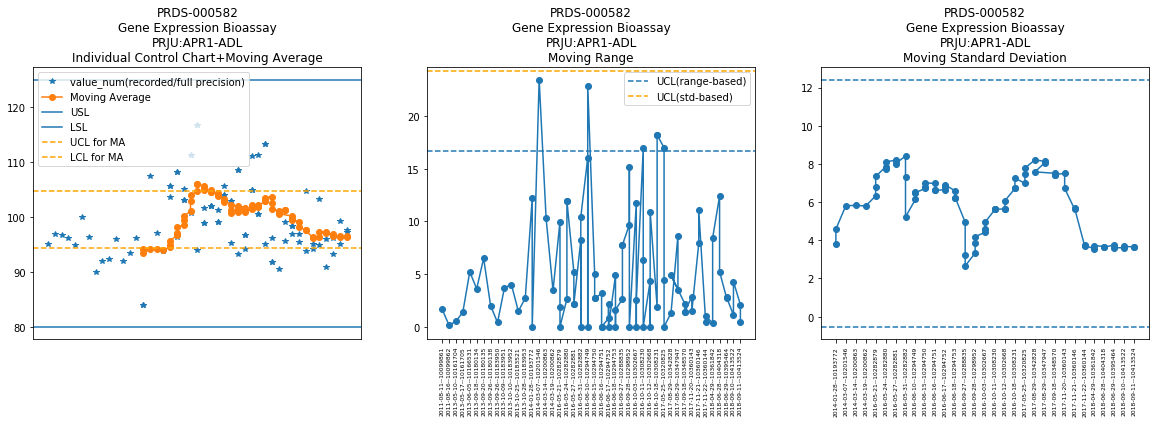

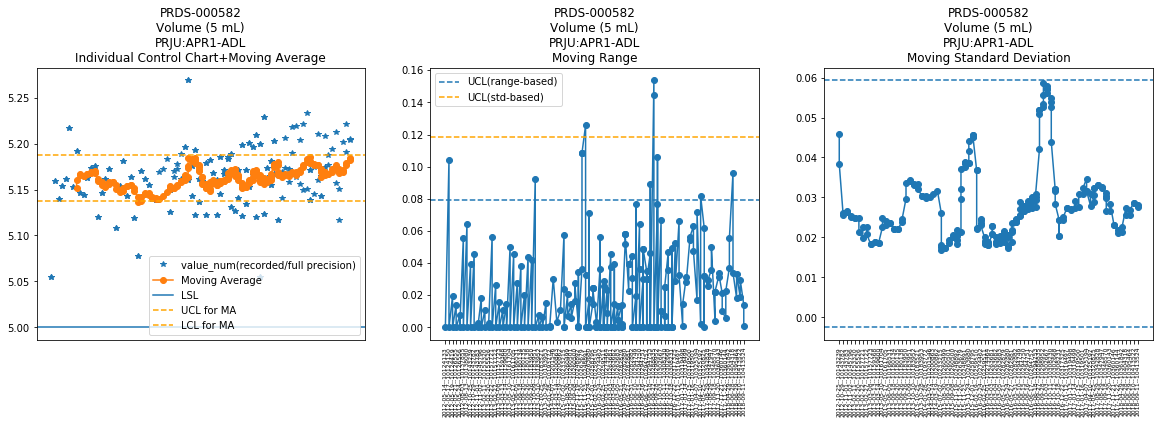

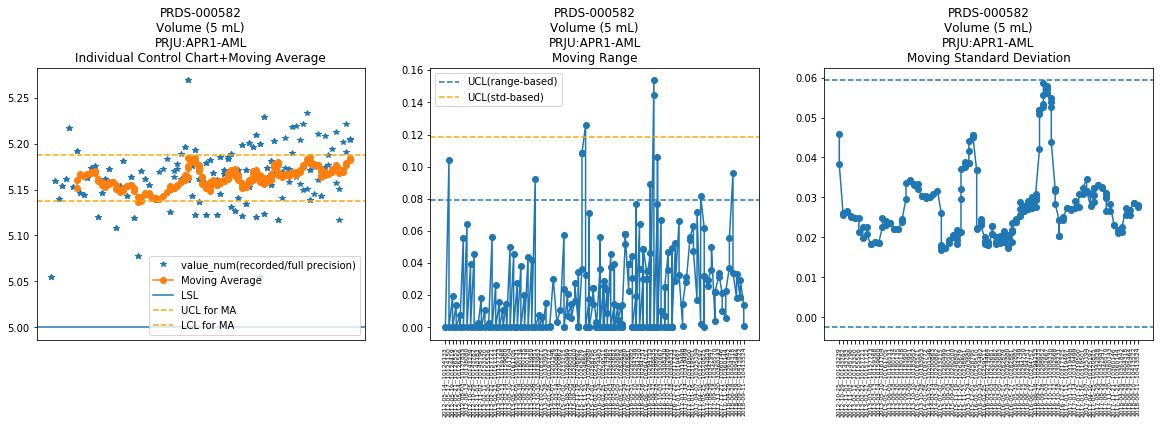

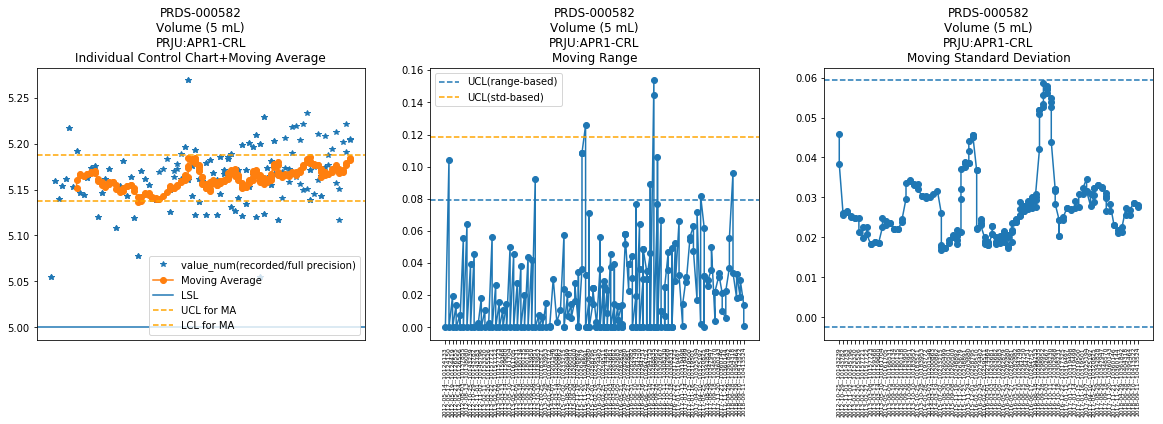

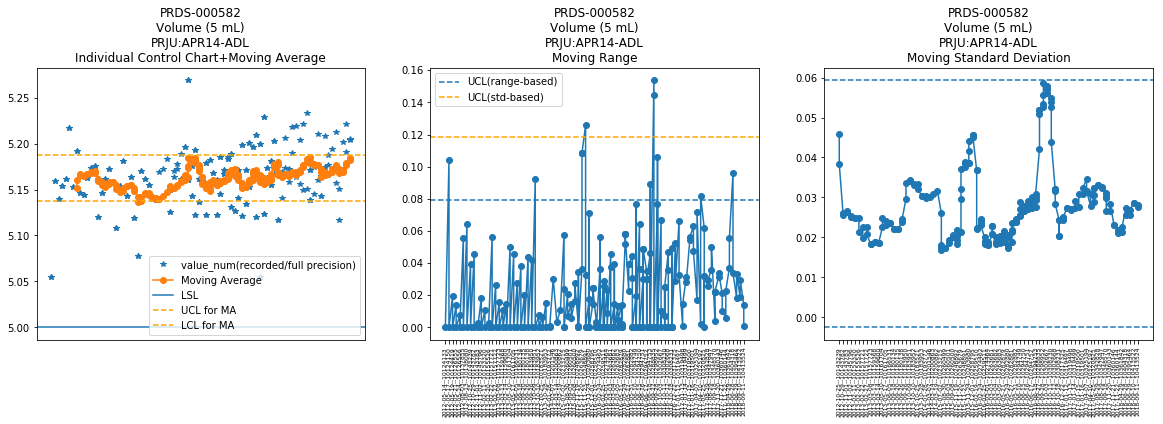

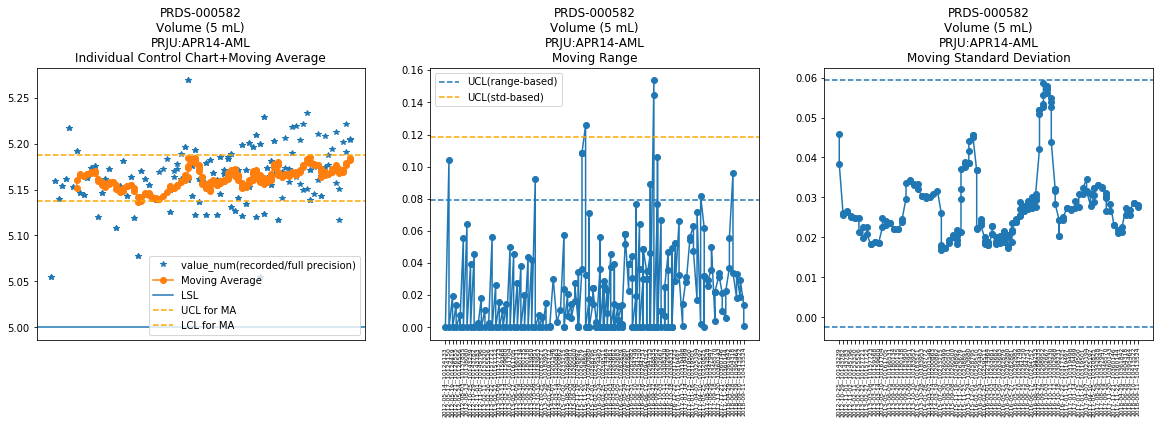

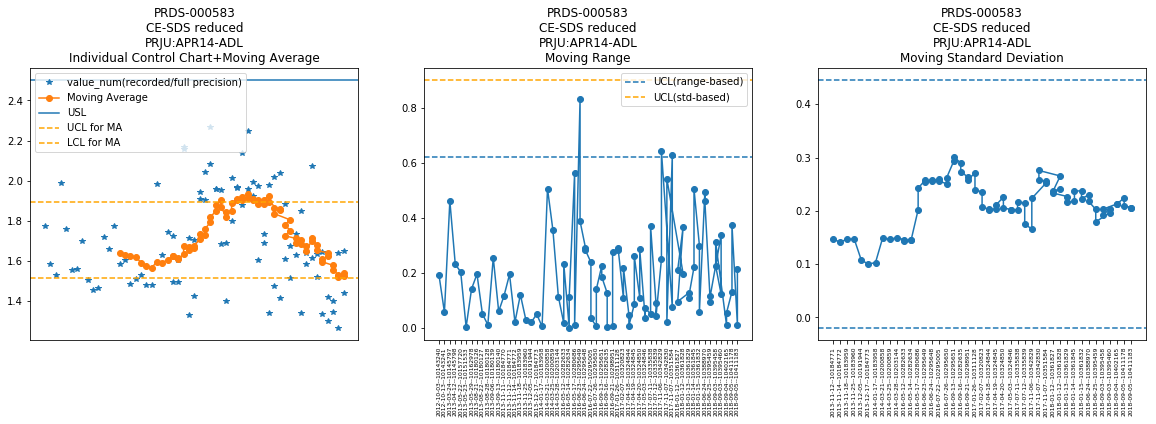

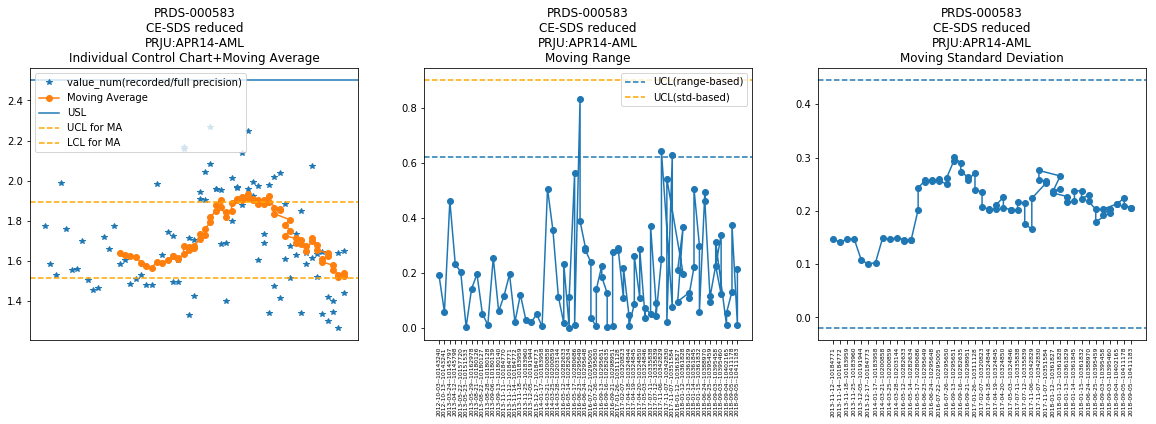

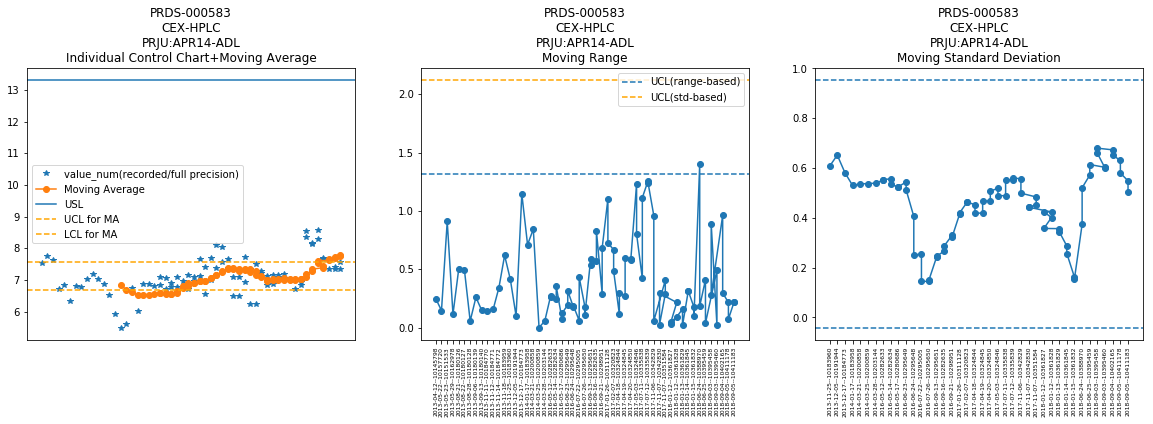

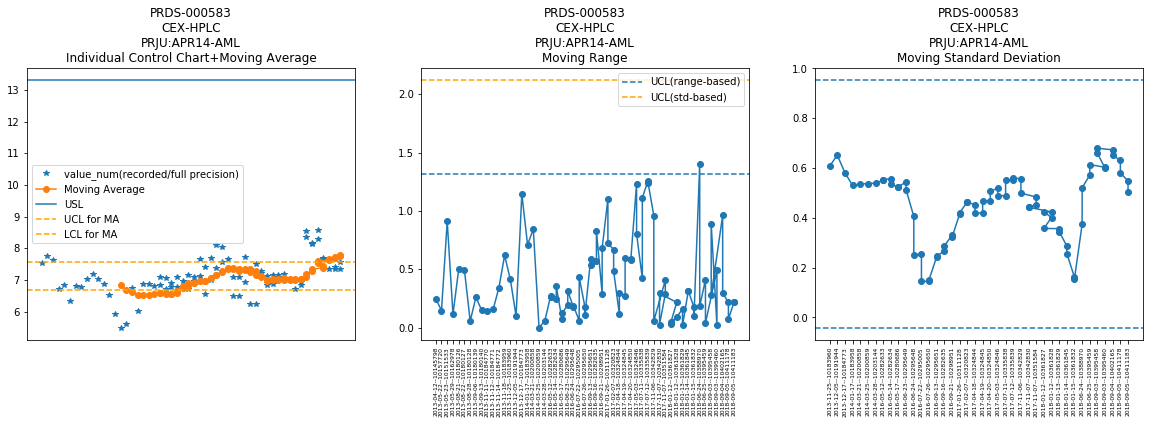

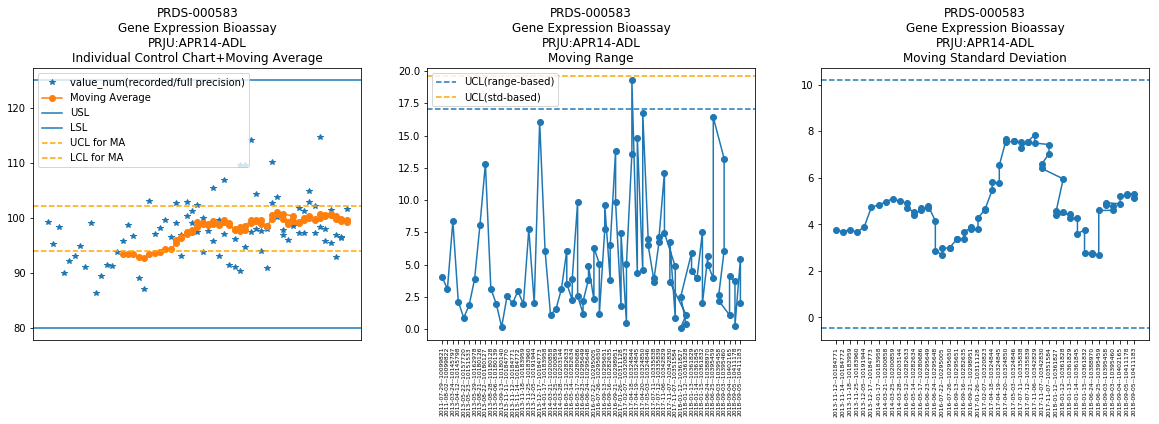

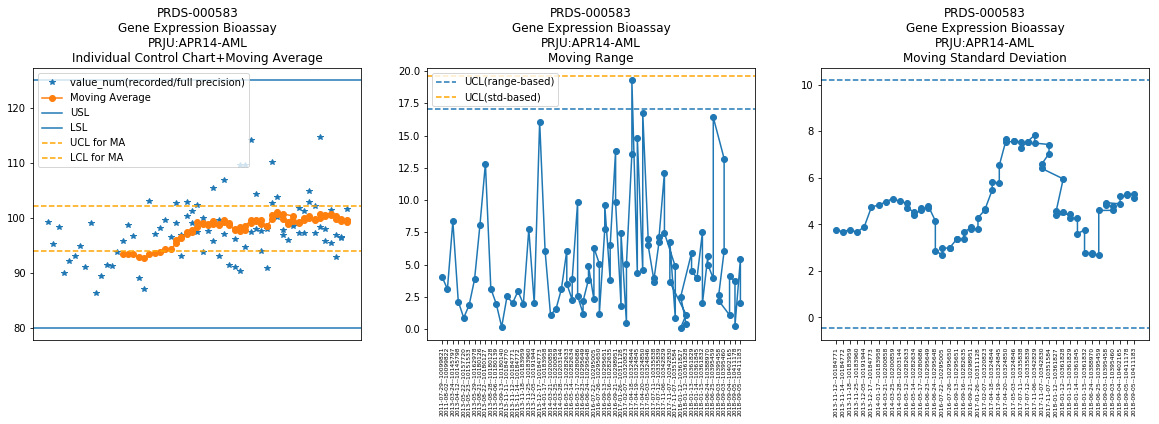

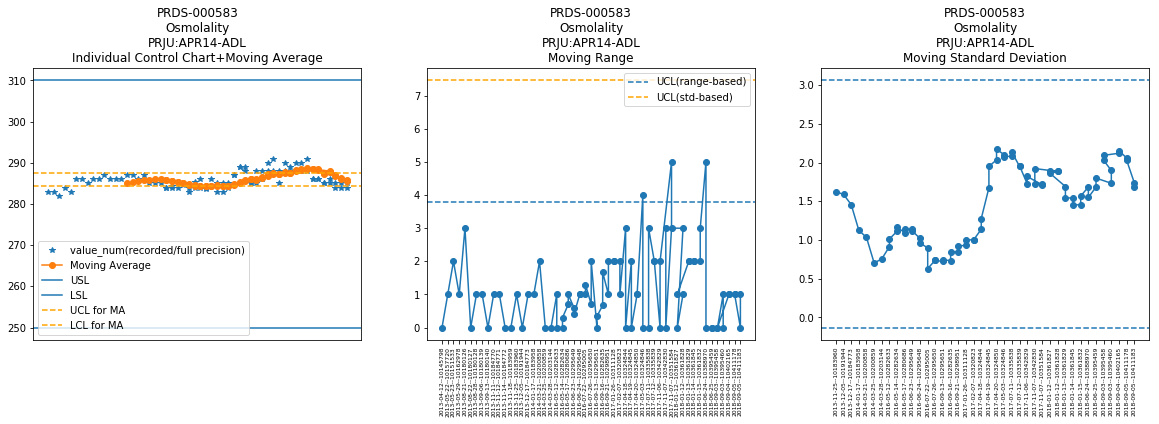

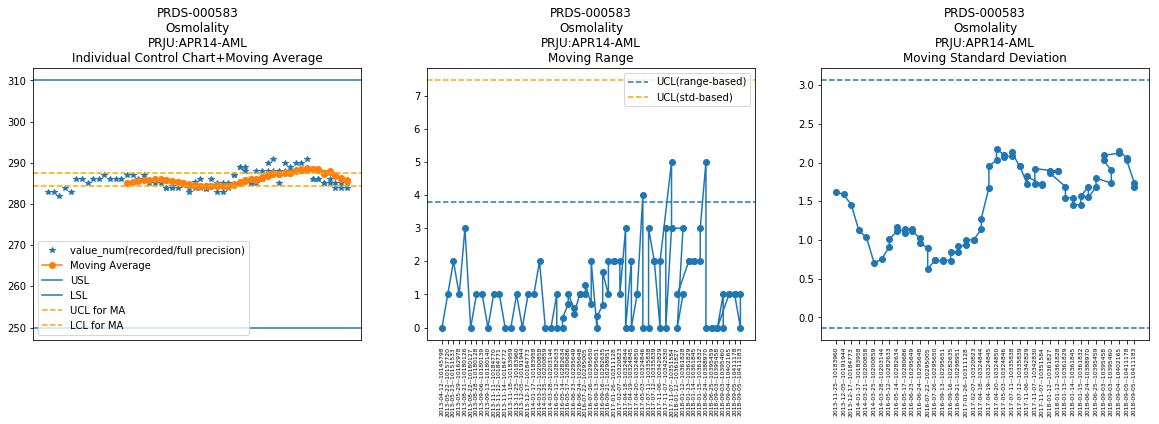

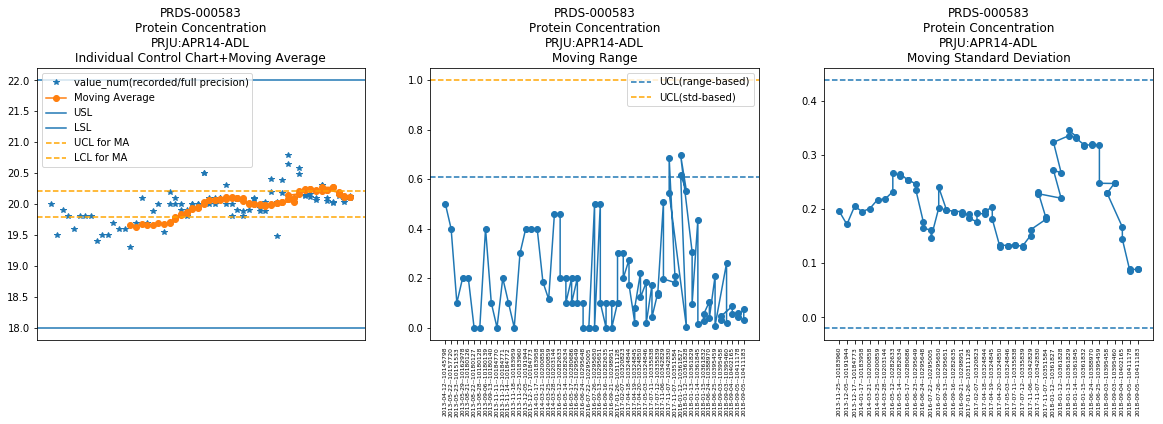

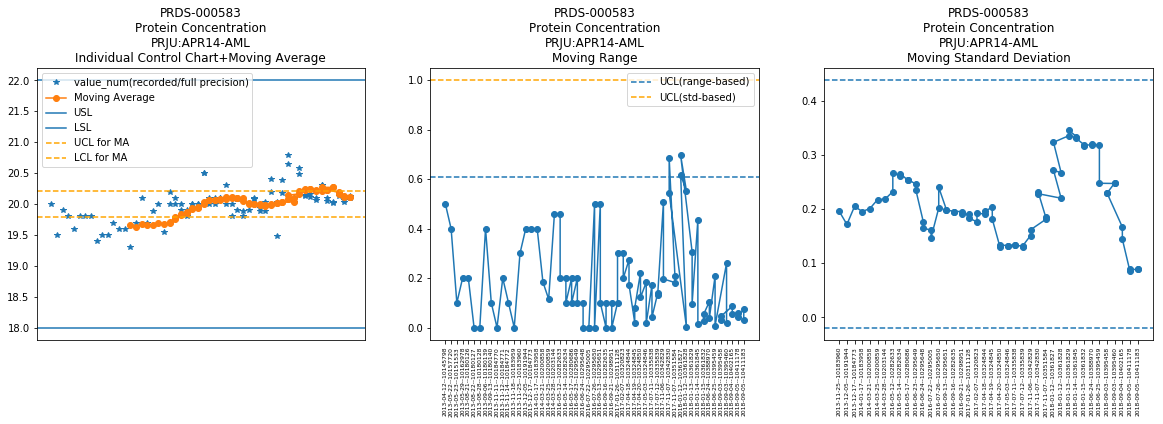

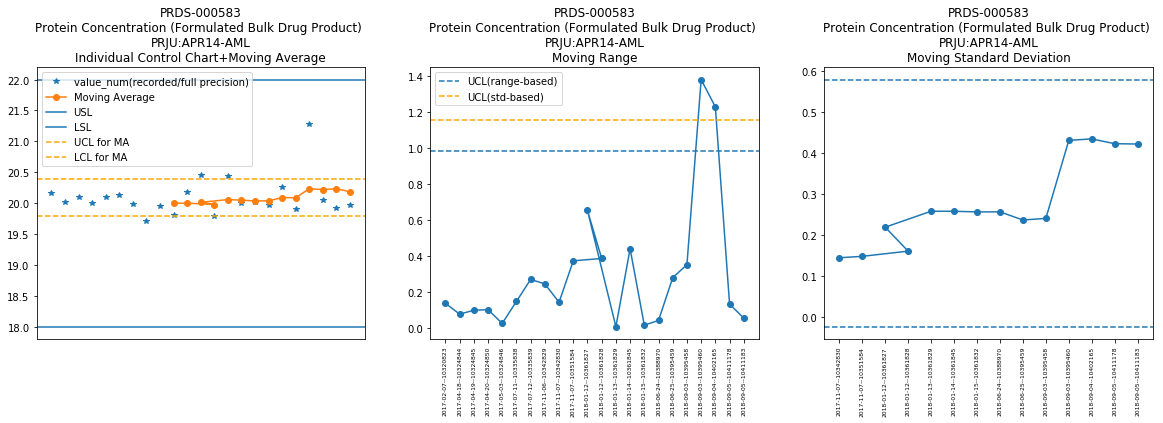

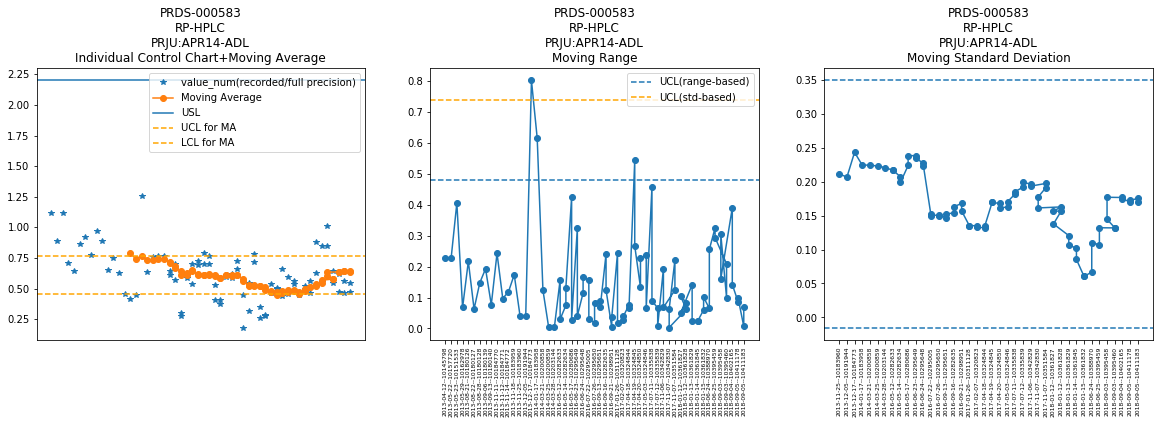

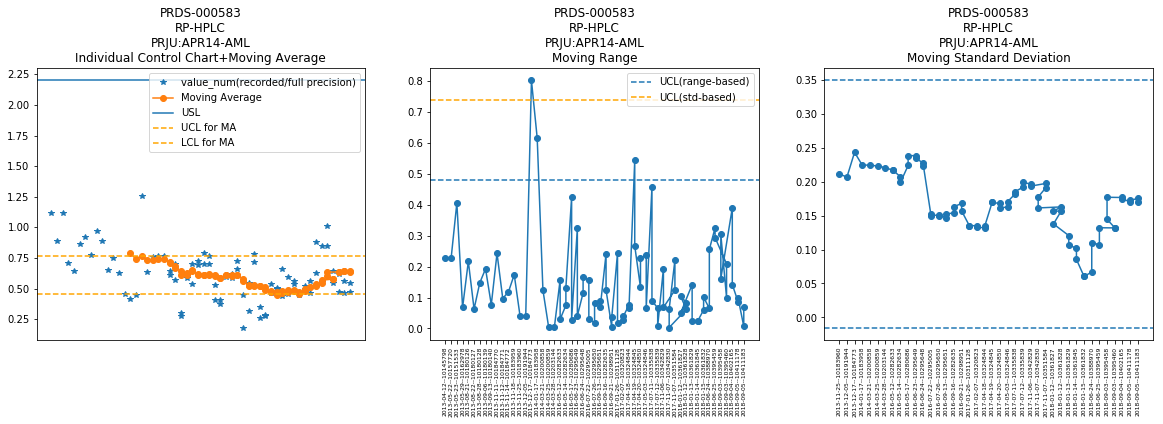

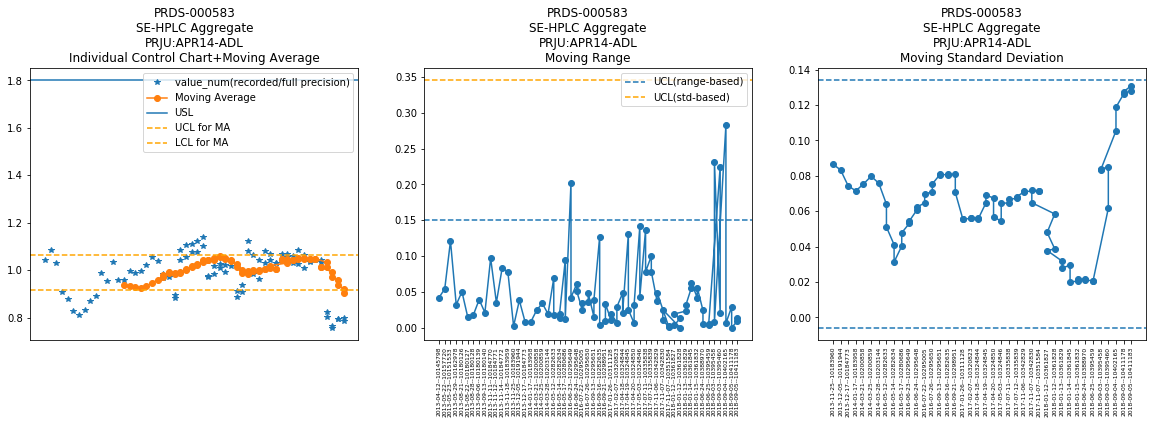

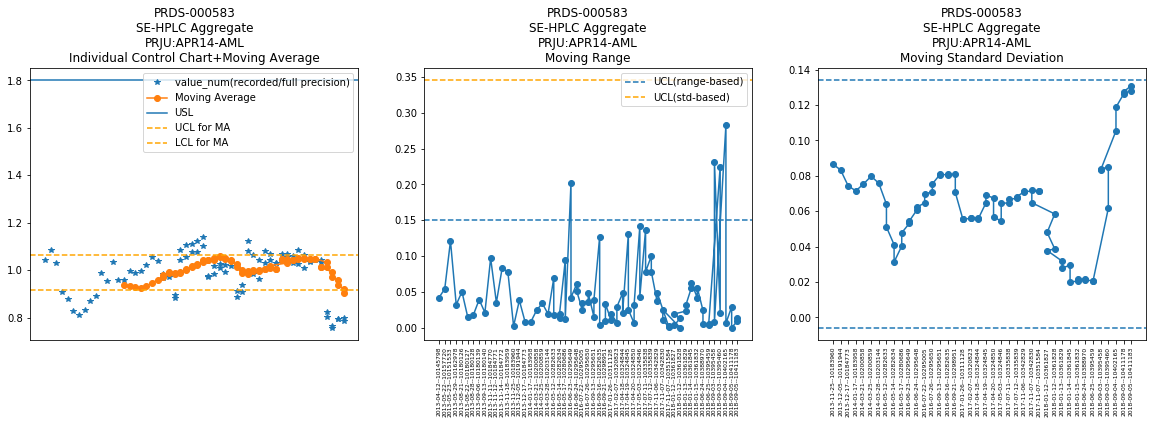

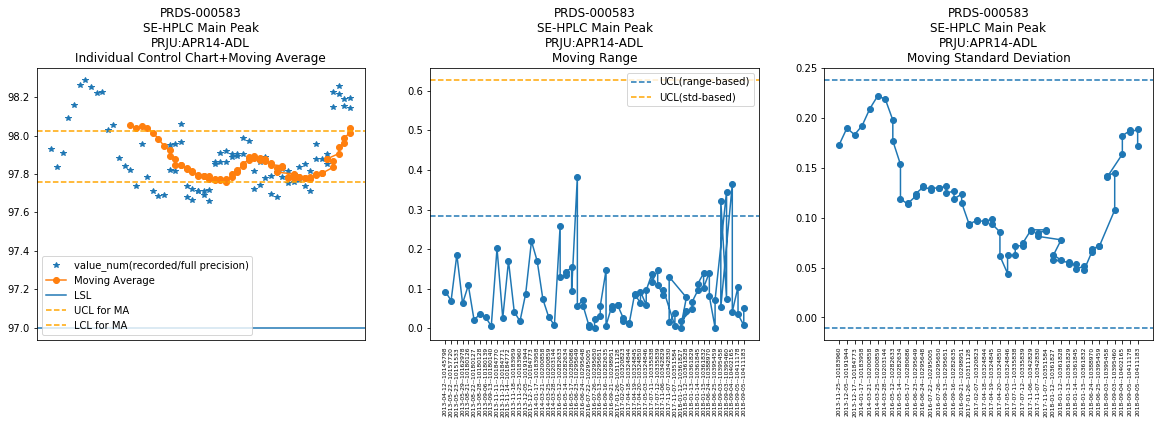

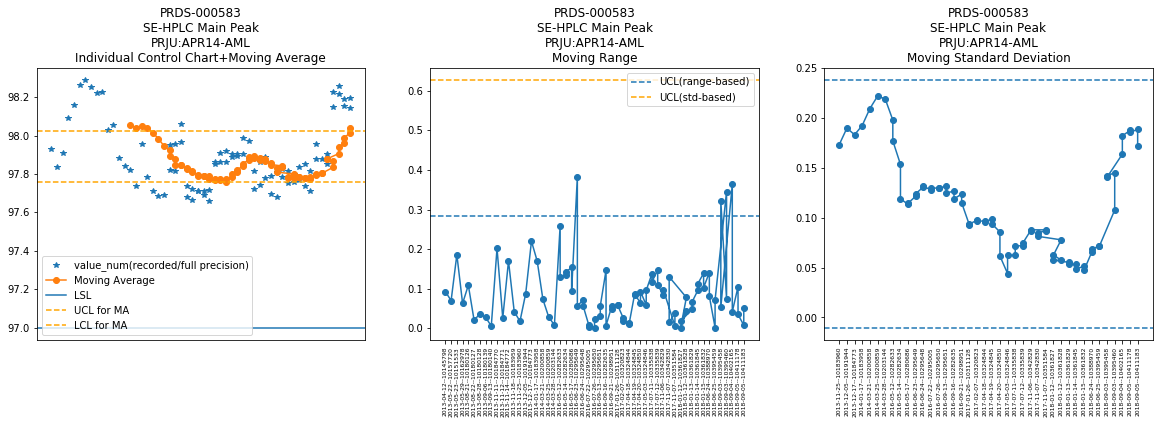

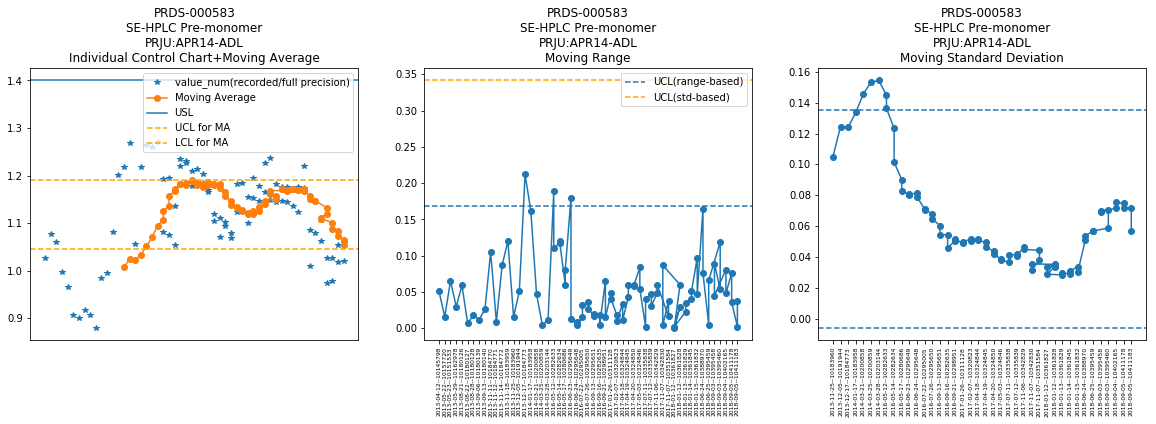

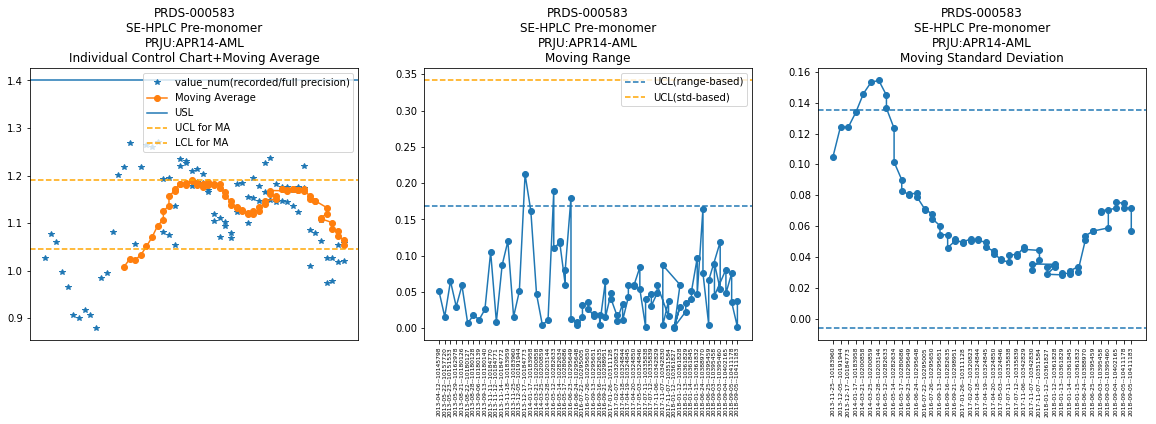

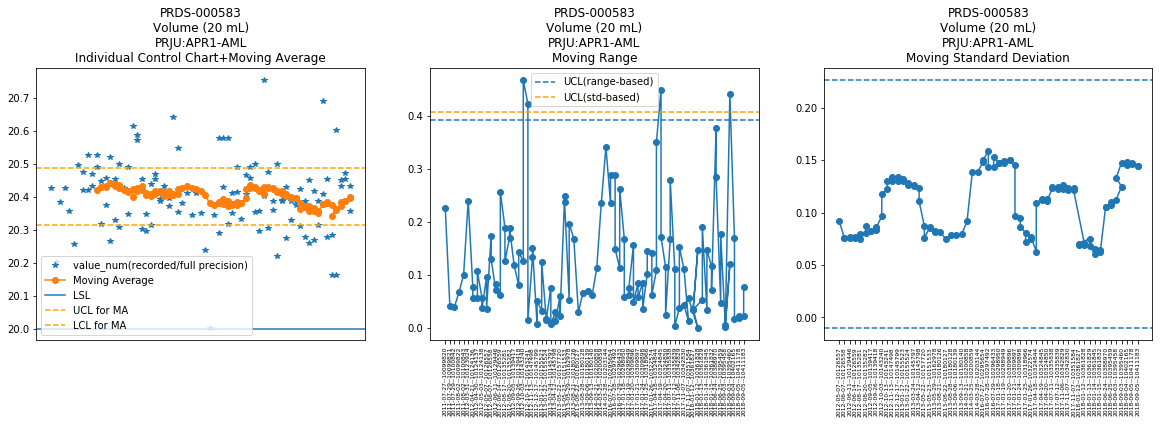

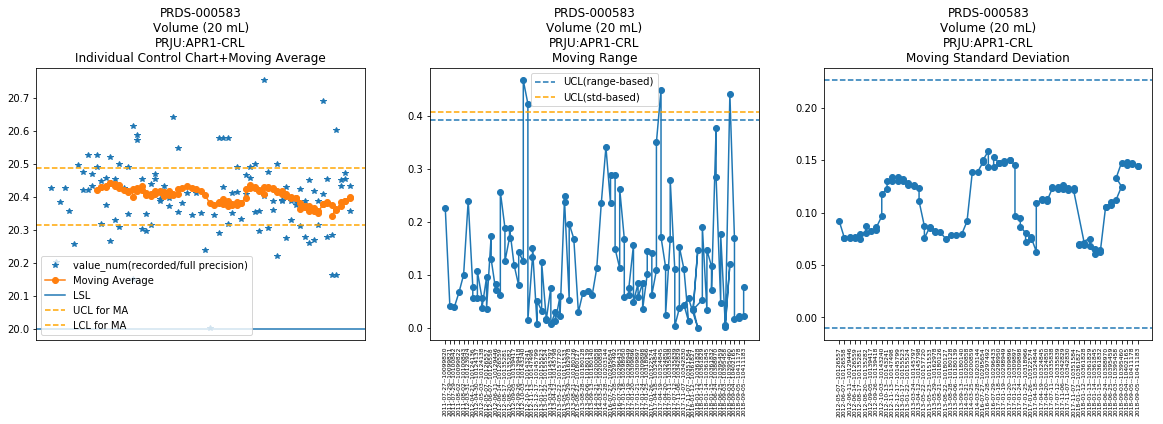

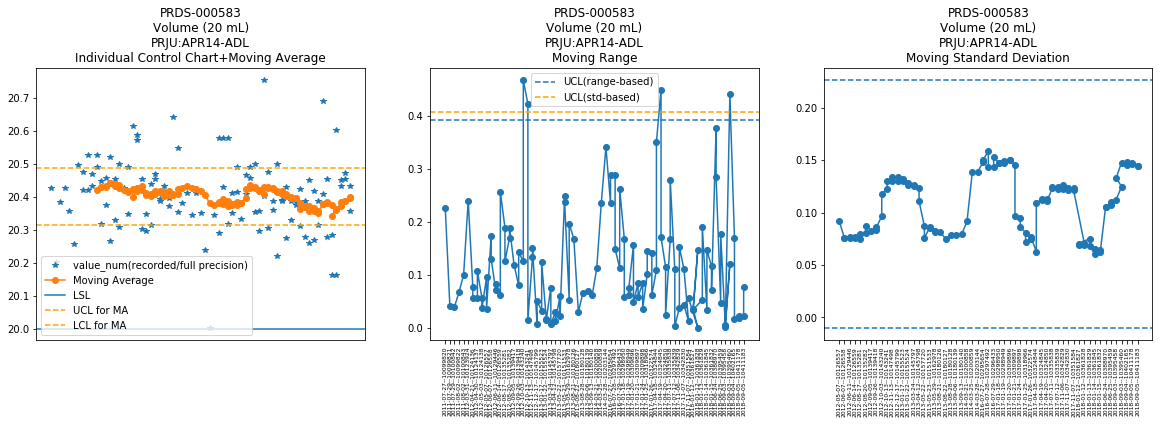

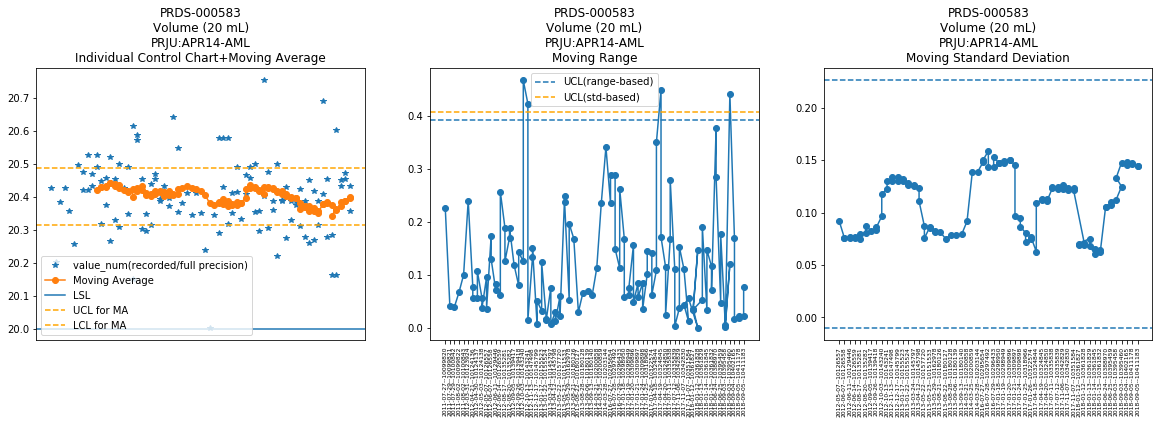

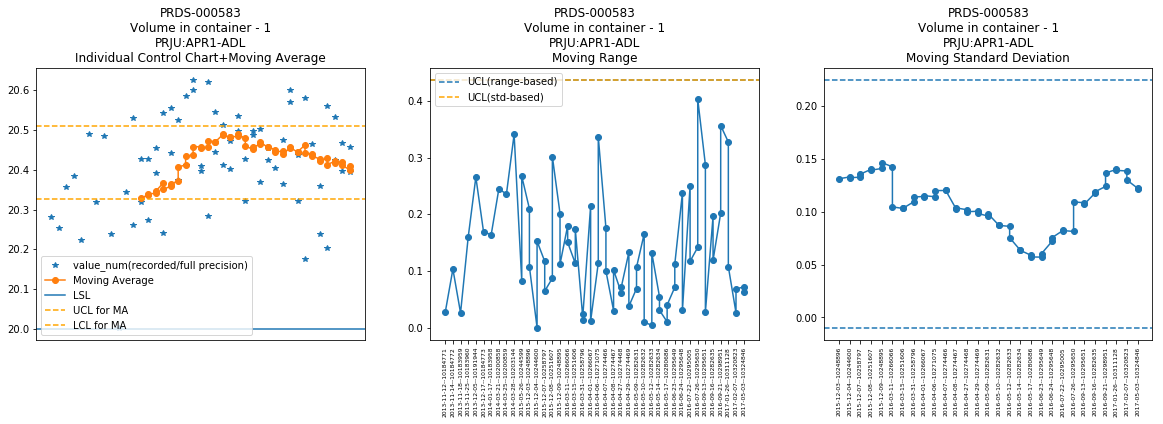

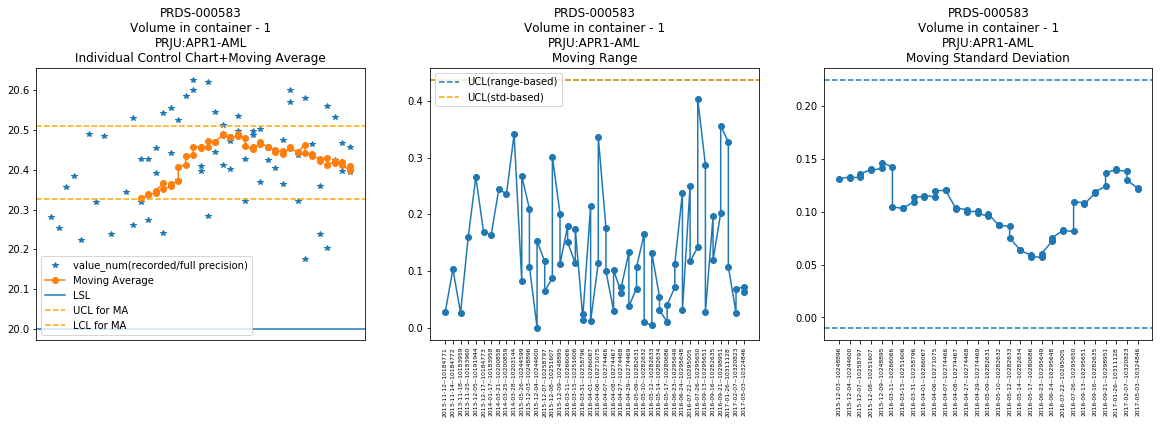

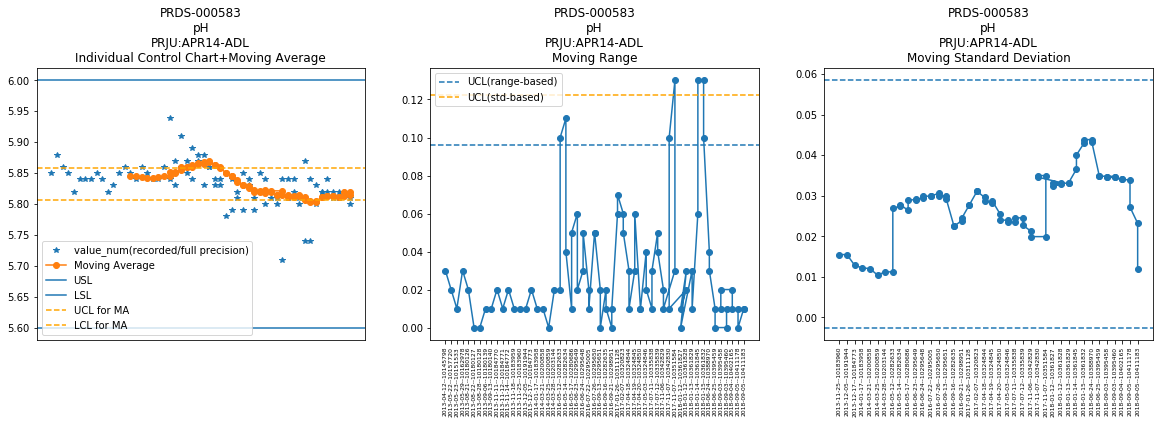

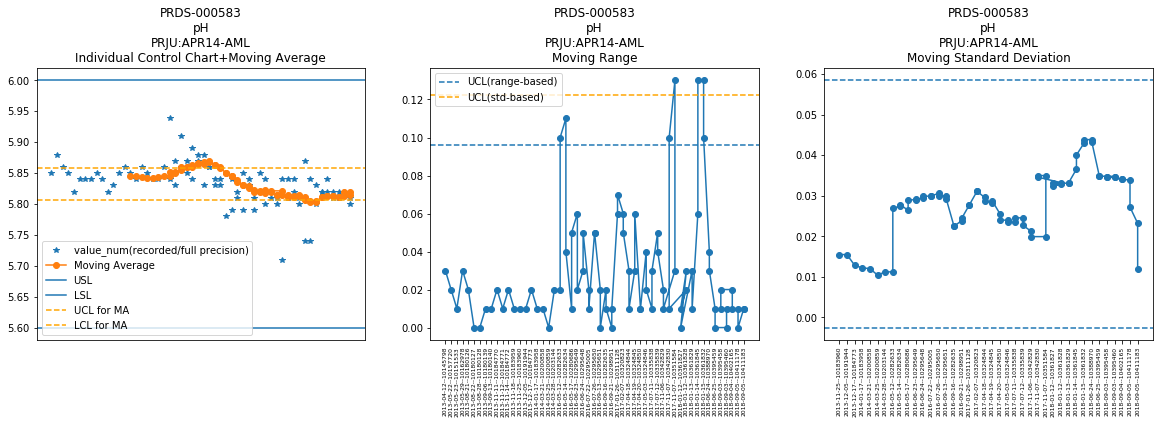

In [159]:
pp = PdfPages('4plots.pdf')
#plt.figure(figsize=(10,75))
for i in range(len(combs)):
    prds=combs["parameter detail"].iloc[i]
    para=combs["parameter name"].iloc[i]
    mfg=combs["Mfg Site"].iloc[i]
    test=combs["Test Site"].iloc[i]
    sub_df=df_quan[(df_quan["parameter detail"]==prds)&(df_quan["parameter name"]==para)].copy()
    sub_df=sub_df.sort_values(by=["date of manufacture"])
    if len(sub_df)>50:
        width=15
    else:
        width=10
    mostd=pd.rolling_std(sub_df['value_num(recorded/full precision)'],window=width)
    moavg=pd.rolling_mean(sub_df['value_num(recorded/full precision)'],window=width)
    mr=np.abs(np.diff(sub_df['value_num(recorded/full precision)']))
    mocv=mostd/moavg*100
    sample_std=np.std(sub_df['value_num(recorded/full precision)'],ddof=1)
    sample_mean=np.average(sub_df['value_num(recorded/full precision)'])
    indexes=mostd[mostd.notnull()].index
    ual=sub_df["UAL"].iloc[-1]
    lal=sub_df["LAL"].iloc[-1]
    #ax=plt.subplot(5,5,i+1)
    ax=plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(sub_df["Mft_Date_Batch"],sub_df['value_num(recorded/full precision)'],"*")
    plt.plot(sub_df["Mft_Date_Batch"].loc[indexes],moavg[indexes],"-o",label="Moving Average")
    if (ual!="."):
        plt.axhline(y=ual,label="USL")
    if(lal!="."):
        plt.axhline(y=lal,label="LSL")  
    plt.axhline(y=sample_mean+3*sample_std/np.sqrt(width),label="UCL for MA",linestyle="--",color="orange")
    plt.axhline(y=sample_mean-3*sample_std/np.sqrt(width),label="LCL for MA",linestyle="--",color="orange")
    
    plt.xticks([], [])
    plt.title(prds+"\n"+para+"\n"+mfg+"-"+test+"\n"+"Individual Control Chart+Moving Average")
    plt.legend()
    #ax.set_title(prds+"\n"+para,fontsize=10)

    
    plt.subplot(1,3,2)
    plt.plot(sub_df["Mft_Date_Batch"].iloc[1:],mr,"-o")
    plt.axhline(y=3.267*np.average(mr),linestyle="--",label="UCL(range-based)")
    plt.axhline(3.678*sample_std,linestyle="--",label="UCL(std-based)",color="orange")
    plt.title(prds+"\n"+para+"\n"+mfg+"-"+test+"\n"+"Moving Range")   
    plt.xticks(rotation=90,fontsize=6)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(sub_df["Mft_Date_Batch"].loc[indexes],mostd[indexes],"-o")
    plt.axhline(y=np.average(mostd[indexes])+3*np.average(mostd[indexes])*0.363,linestyle="--",label="UCL")
    plt.axhline(y=np.average(mostd[indexes])-3*np.average(mostd[indexes])*0.363,linestyle="--",label="LCL")
    plt.title(prds+"\n"+para+"\n"+mfg+"-"+test+"\n"+"Moving Standard Deviation")

    #plt.title(prds+"\n"+para+"\n"+mfg+"-"+test+"\n"+"Moving Coefficient of Variation(%)")
    
    plt.xticks(rotation=90,fontsize=6)
    
    plt.savefig(pp, format='pdf',bbox_inches="tight");
pp.close()

In [143]:
df_quan.groupby(['parameter detail', 'parameter name']).size()

parameter detail  parameter name                                       
PRDS-000582       CE-SDS reduced                                           24
                  CEX-HPLC                                                 24
                  Gene Expression Bioassay                                 26
                  Osmolality                                               24
                  Protein Concentration                                    24
                  Protein Concentration (Formulated Bulk Drug Product)     12
                  RP-HPLC                                                  24
                  SE-HPLC Aggregate                                        24
                  SE-HPLC Main Peak                                        24
                  SE-HPLC Pre-monomer                                      24
                  Volume (5 mL)                                            44
                  pH                                                  

In [ ]:
    plt.subplot(1,3,2)
    plt.plot(sub_df["Mft_Date_Batch"].loc[indexes],moavg[indexes],"-o")
    if (ual!="."):
        plt.axhline(y=ual,color="orange")
    if(lal!="."):
        plt.axhline(y=lal,color="orange")
    plt.title(prds+"\n"+para+"\n"+mfg+"-"+test+"\n"+"Moving Average")
    plt.xticks(rotation=90,fontsize=6);

In [4]:
df2=pd.read_csv("Vex.csv",index_col=False)

In [5]:
df2["Manufacture Date"]=pd.to_datetime(df2["Manufacture Date"])

In [6]:
df2=df2.sort_values(['Specification','method_number','Measurement',"Manufacture Date"])

In [16]:
len(df2[['Specification','method_number',"Measurement","Batch Number","Manufacture Date","test_site",\
                  "Measured Value","Result Authorization Time"]].drop_duplicates())

426

In [19]:
sum(df2["Release Test"])

122

In [8]:
sub_df_dict={}

In [9]:
combs=df2[['Specification','method_number',"Measurement"]].drop_duplicates()

In [10]:
len(combs)

14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  from ipykernel import kernelapp as app


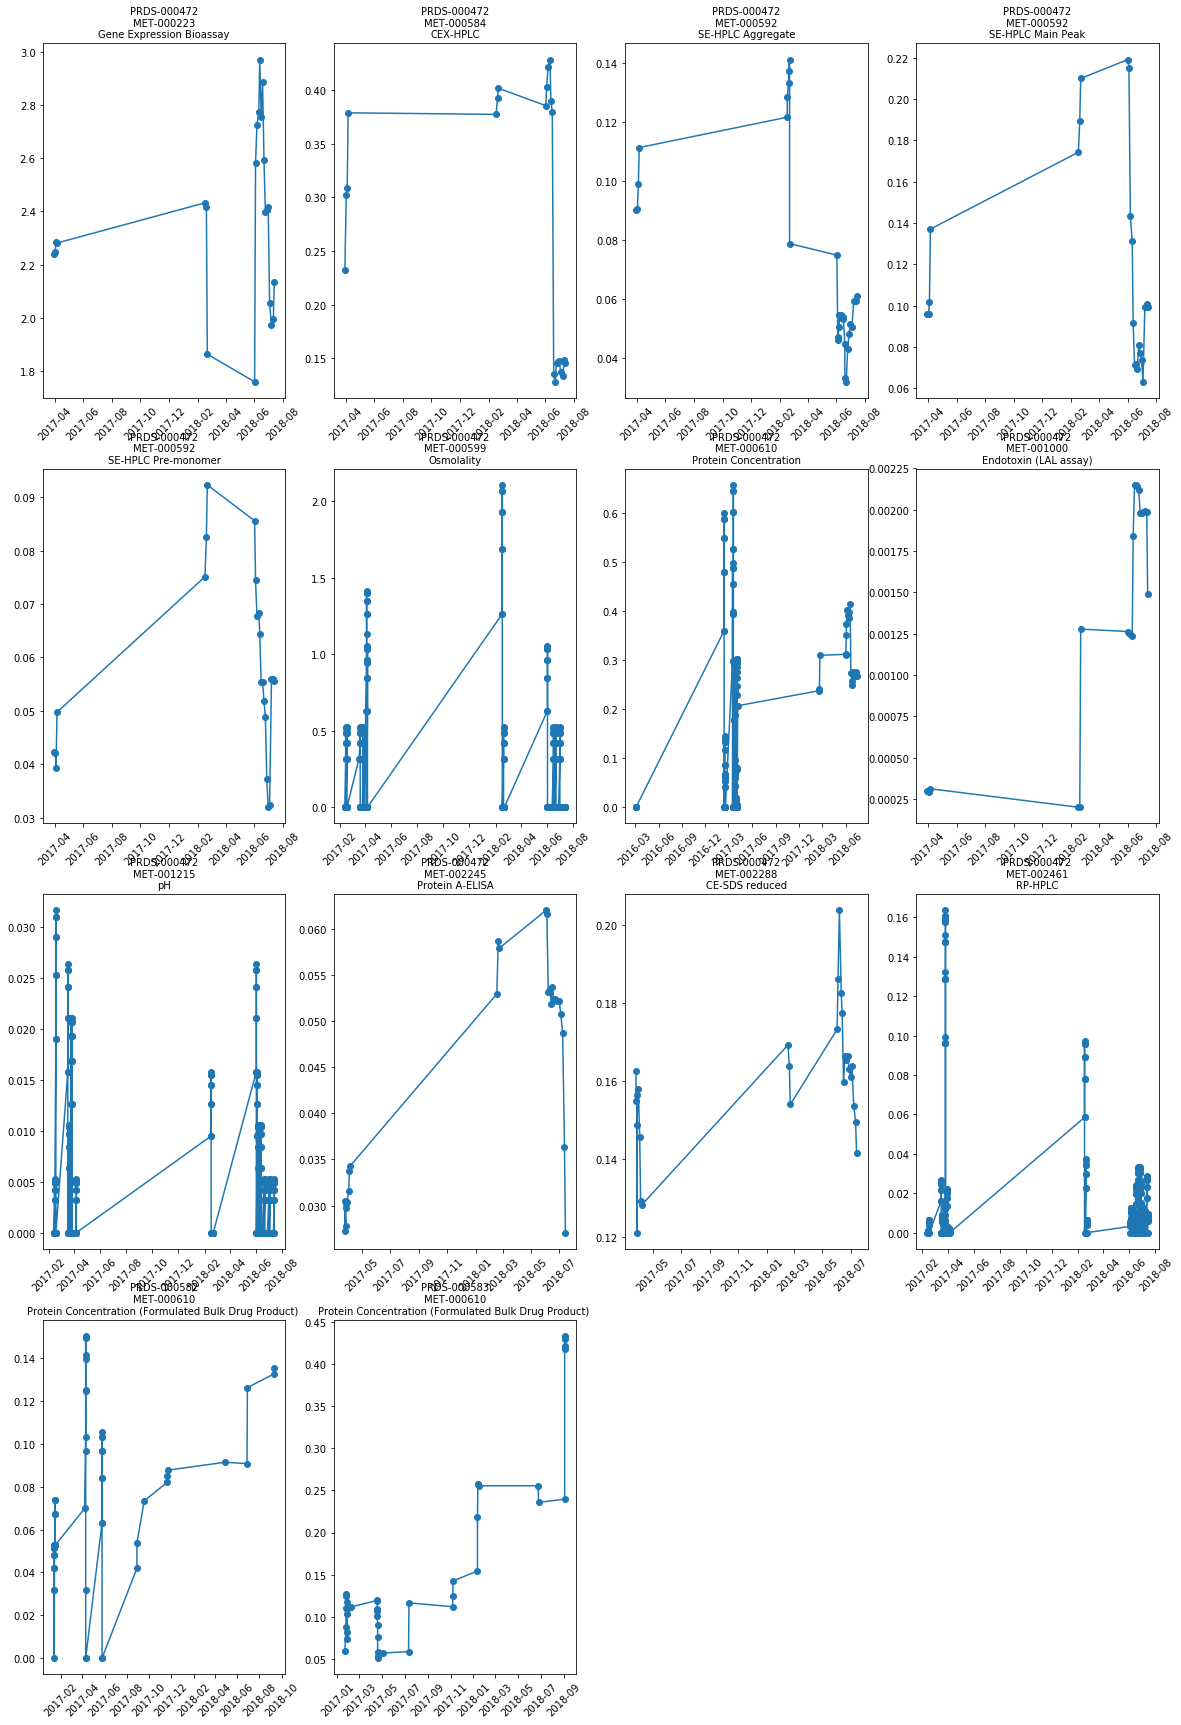

In [11]:
plt.figure(figsize=(20,30))
for i in range(len(combs)):
    spec=combs['Specification'].iloc[i]
    met=combs['method_number'].iloc[i]
    meas=combs['Measurement'].iloc[i]
    sub_df=df2.loc[(df2['Specification']==spec)&\
               (df2["method_number"]==met)&\
                    (df2["Measurement"]==meas)].copy()
    sub_df=sub_df.sort_values(by="Manufacture Date")
    sub_df=sub_df[['Specification','method_number',"Measurement","Batch Number","Manufacture Date","test_site",\
                  "Measured Value","Result Authorization Time"]]
    #.drop_duplicates()
    sub_df_dict[(spec,met,meas)]=sub_df
    if len(sub_df>=50):
        width=10
    else:
        width=5
    mostd=pd.rolling_std(sub_df["Measured Value"],window=width)
    indexes=mostd[mostd.notnull()].index
    ax=plt.subplot(4,4,i+1)

    ax.set_title(spec+"\n"+met+"\n"+meas,fontsize=10)
    plt.plot(sub_df["Manufacture Date"].loc[indexes],mostd[indexes],"-o")
    plt.xticks(rotation=45);
    #sub_df["Values"]
#plt.legend();

In [12]:
sub_df_dict[('PRDS-000472', 'MET-000223', 'Gene Expression Bioassay')]

Specification method_number               Measurement  Batch Number  \
1323   PRDS-000472    MET-000223  Gene Expression Bioassay      10316998   
345    PRDS-000472    MET-000223  Gene Expression Bioassay      10316999   
1014   PRDS-000472    MET-000223  Gene Expression Bioassay      10317000   
179    PRDS-000472    MET-000223  Gene Expression Bioassay      10319100   
503    PRDS-000472    MET-000223  Gene Expression Bioassay      10319101   
1532   PRDS-000472    MET-000223  Gene Expression Bioassay      10319102   
856    PRDS-000472    MET-000223  Gene Expression Bioassay      10319103   
491    PRDS-000472    MET-000223  Gene Expression Bioassay      10319104   
1279   PRDS-000472    MET-000223  Gene Expression Bioassay      10347480   
774    PRDS-000472    MET-000223  Gene Expression Bioassay      10319105   
1120   PRDS-000472    MET-000223  Gene Expression Bioassay      10319106   
1102   PRDS-000472    MET-000223  Gene Expression Bioassay      10319107   
5      PRDS-000472    MET-000223  Gene Expression Bioassay      10319109   
23     PRDS-000472    MET-000223  Gene Expression Bioassay      10362165   
815    PRDS-000472    MET-000223  Gene Expression Bioassay      10362167   
736    PRDS-000472    MET-000223  Gene Expression Bioassay      10362168   
58     PRDS-000472    MET-000223  Gene Expression Bioassay      10387996   
1484   PRDS-000472    MET-000223  Gene Expression Bioassay      10387997   
756    PRDS-000472    MET-000223  Gene Expression Bioassay      10387998   
252    PRDS-000472    MET-000223  Gene Expression Bioassay      10387999   
1530   PRDS-000472    MET-000223  Gene Expression Bioassay      10388000   
1609   PRDS-000472    MET-000223  Gene Expression Bioassay      10388001   
1518   PRDS-000472    MET-000223  Gene Expression Bioassay      10388002   
807    PRDS-000472    MET-000223  Gene Expression Bioassay      10388003   
41     PRDS-000472    MET-000223  Gene Expression Bioassay      10388004   
413    PRDS-000472    MET-000223  Gene Expression Bioassay      10388005   
670    PRDS-000472    MET-000223  Gene Expression Bioassay      10388006   
1121   PRDS-000472    MET-000223  Gene Expression Bioassay      10388007   
466    PRDS-000472    MET-000223  Gene Expression Bioassay      10388008   
706    PRDS-000472    MET-000223  Gene Expression Bioassay      10388009   
642    PRDS-000472    MET-000223  Gene Expression Bioassay      10388010   

     Manufacture Date test_site  Measured Value Result Authorization Time  
1323       2017-02-12       ARI         101.728       2017/02/27 17:05:55  
345        2017-02-14       ARI          98.756       2017/02/27 17:05:56  
1014       2017-02-17       ARI         103.122       2017/02/27 17:05:56  
179        2017-03-17       ARI         102.890       2017/04/04 17:05:03  
503        2017-03-20       ARI          98.300       2017/04/04 17:05:03  
1532       2017-03-22       ARI         105.950       2017/04/04 17:05:03  
856        2017-03-25       ARI         102.550       2017/04/04 17:05:03  
491        2017-03-27       ARI         100.800       2017/04/06 18:38:24  
1279       2017-03-27       ARI         100.640       2017/10/18 13:21:49  
774        2017-03-30       ARI         100.690       2017/04/06 18:38:24  
1120       2017-04-02       ARI         102.200       2017/04/06 18:38:24  
1102       2017-04-04       ARI          98.500       2017/04/14 18:02:05  
5          2017-04-06       ARI         103.060       2017/04/14 18:02:05  
23         2018-02-16       ARI          98.360       2018/03/08 18:39:04  
815        2018-02-19       ARI          98.410       2018/03/08 18:39:04  
736        2018-02-21       ARI         102.840       2018/03/08 18:39:04  
58         2018-06-02       ARI         100.600       2018/06/14 20:23:10  
1484       2018-06-04       ARI         106.570       2018/06/14 20:23:10  
756        2018-06-07       ARI         104.070       2018/06/28 18:26:36  
252        2018-06-11       ARI         103.500     

In [14]:
sub_df[['Specification','method_number',"Measurement","Batch Number","Manufacture Date","test_site",\
                  "Measured Value","Result Authorization Time"]]

Specification method_number  \
1224   PRDS-000583    MET-000610   
1642   PRDS-000583    MET-000610   
1643   PRDS-000583    MET-000610   
1644   PRDS-000583    MET-000610   
677    PRDS-000583    MET-000610   
678    PRDS-000583    MET-000610   
704    PRDS-000583    MET-000610   
863    PRDS-000583    MET-000610   
864    PRDS-000583    MET-000610   
865    PRDS-000583    MET-000610   
879    PRDS-000583    MET-000610   
877    PRDS-000583    MET-000610   
878    PRDS-000583    MET-000610   
1492   PRDS-000583    MET-000610   
0      PRDS-000583    MET-000610   
1      PRDS-000583    MET-000610   
2      PRDS-000583    MET-000610   
3      PRDS-000583    MET-000610   
858    PRDS-000583    MET-000610   
1265   PRDS-000583    MET-000610   
1365   PRDS-000583    MET-000610   
1364   PRDS-000583    MET-000610   
1366   PRDS-000583    MET-000610   
1362   PRDS-000583    MET-000610   
1363   PRDS-000583    MET-000610   
1625   PRDS-000583    MET-000610   
1626   PRDS-000583    MET-000610   
1627   PRDS-000583    MET-000610   
1628   PRDS-000583    MET-000610   
1629   PRDS-000583    MET-000610   
1082   PRDS-000583    MET-000610   
987    PRDS-000583    MET-000610   
1042   PRDS-000583    MET-000610   
1338   PRDS-000583    MET-000610   
6      PRDS-000583    MET-000610   
1483   PRDS-000583    MET-000610   
1359   PRDS-000583    MET-000610   
19     PRDS-000583    MET-000610   
811    PRDS-000583    MET-000610   
857    PRDS-000583    MET-000610   
1605   PRDS-000583    MET-000610   
21     PRDS-000583    MET-000610   
860    PRDS-000583    MET-000610   
735    PRDS-000583    MET-000610   
890    PRDS-000583    MET-000610   
1516   PRDS-000583    MET-000610   
67     PRDS-000583    MET-000610   
134    PRDS-000583    MET-000610   
814    PRDS-000583    MET-000610   

                                            Measurement  Batch Number  \
1224  Protein Concentration (Formulated Bulk Drug Pr...      10298950   
1642  Protein Concentration (Formulated Bulk Drug Pr...      10298949   
1643  Protein Concentration (Formulated Bulk Drug Pr...      10298949   
1644  Protein Concentration (Formulated Bulk Drug Pr...      10298949   
677   Protein Concentration (Formulated Bulk Drug Pr...      10309896   
678   Protein Concentration (Formulated Bulk Drug Pr...      10309896   
704   Protein Concentration (Formulated Bulk Drug Pr...      10309896   
863   Protein Concentration (Formulated Bulk Drug Pr...      10309897   
864   Protein Concentration (Formulated Bulk Drug Pr...      10309897   
865   Protein Concentration (Formulated Bulk Drug Pr...      10309897   
879   Protein Concentration (Formulated Bulk Drug Pr...      10309898   
877   Protein Concentration (Formulated Bulk Drug Pr...      10309898   
878   Protein Concentration (Formulated Bulk Drug Pr...      10309898   
1492  Protein Concentration (Formulated Bulk Drug Pr...      10318966   
0     Protein Concentration (Formulated Bulk Drug Pr...      10322574   
1     Protein Concentration (Formulated Bulk Drug Pr...      10322574   
2     Protein Concentration (Formulated Bulk Drug Pr...      10322574   
3     Protein Concentration (Formulated Bulk Drug Pr...      10322574   
858   Protein Concentration (Formulated Bulk Drug Pr...      10311128   
1265  Protein Concentration (Formulated Bulk Drug Pr...      10320823   
1365  Protein Concentration (Formulated Bulk Drug Pr...      10324844   
1364  Protein Concentration (Formulated Bulk Drug Pr...      10324844   
1366  Protein Concentration (Formulated Bulk Drug Pr...      10324844   
1362  Protein Concentration (Formulated Bulk Drug Pr...      10324844   
1363  Protein Concentration (Formulated Bulk Drug Pr...      10324844   
1625  Protein Concentration (Formulated Bulk Drug Pr...      10324845   
1626  Protein Concentration (Formulated Bulk Drug Pr...      10324845   
1627  Protein Concentration (Formulated Bulk Drug Pr...      10324845   
1628  Protein Concentration (Formulated Bulk Drug Pr...      10324845   
1629  Protein 

In [222]:
tt=df2[['Specification','method_number',"Measurement","Batch Number","Manufacture Date","test_site",\
                  "Measured Value","Result Authorization Time"]].drop_duplicates()

In [ ]:
plt.plot(sub_df["Manufacture Date"].loc[~pd.rolling_std(sub_df["Value"],window=5).isnull()],\
                        pd.rolling_std(sub_df["Value"],window=5).loc[pd.rolling_std(sub_df["Value"],window=5).notnull()],"o")

In [223]:
tt.groupby(['Specification','method_number','Measurement']).size()

Specification  method_number  Measurement                                          
PRDS-000472    MET-000223     Gene Expression Bioassay                                 31
               MET-000584     CEX-HPLC                                                 31
               MET-000592     SE-HPLC Aggregate                                        31
                              SE-HPLC Main Peak                                        31
                              SE-HPLC Pre-monomer                                      31
               MET-000599     Osmolality                                               31
               MET-000610     Protein Concentration                                    35
               MET-001000     Endotoxin (LAL assay)                                    31
               MET-001215     pH                                                       31
               MET-002245     Protein A-ELISA                                          31
               M

In [48]:
quan_df['Result Authorization Time']=pd.to_datetime(quan_df['Result Authorization Time'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
quan_df['Manufacture Date']=pd.to_datetime(quan_df['Manufacture Date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [229]:
sub_df=sub_df[['Specification','method_number',"Measurement","Batch Number","Manufacture Date","test_site",\
                  "Measured Value","Result Authorization Time"]].drop_duplicates()

In [91]:
quan_df_2yr=quan_df[quan_df['Result Authorization Time']>datetime.date(2016, 11, 28)]

In [92]:
sum(quan_df_2yr.groupby(['Specification',"Method Number","Measurement",'Test Number']).size()>1)

547

In [96]:
for i in range(len(combs)):
    sub_df=quan_df_2yr.loc[(quan_df_2yr['Specification']==combs['Specification'].iloc[i])&\
               (quan_df_2yr["Method Number"]==combs["Method Number"].iloc[i])&\
                    (quan_df_2yr["Measurement"]==combs["Measurement"].iloc[i])].copy()
    sub_df=sub_df.sort_values(by="Manufacture Date")
    sub_df_dict[(combs['Specification'].iloc[i],combs['Method Number'].iloc[i],combs['Measurement'].iloc[i])]=sub_df
    #sub_df["Values"]

In [107]:
sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]

Batch Number MFG Site:Building  Test Number Sample Destination  \
43168      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43180      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43179      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43181      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43178      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43176      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43175      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43177      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43173      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43172      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43171      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43170      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43169      10316998          USRI:AR5   12789385.0          ARI05_MFG   
43174      10316998          USRI:AR5   12789385.0          ARI05_MFG   
37058      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37069      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37068      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37067      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37059      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37057      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37051      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37055      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37054      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37053      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37052      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37050      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37049      10316999          USRI:AR5   12789533.0          ARI05_MFG   
37056      10316999          USRI:AR5   12789533.0          ARI05_MFG   
41581      10317000          USRI:AR5   12789614.0          ARI05_MFG   
41582      10317000          USRI:AR5   12789614.0          ARI05_MFG   
...             ...               ...          ...                ...   
37377      10388008          USRI:AR5   14292789.0          ARI05_MFG   
37369      10388008          USRI:AR5   14292789.0          ARI05_MFG   
37368      10388008          USRI:AR5   14292789.0          ARI05_MFG   
37367      10388008          USRI:AR5   14292789.0          ARI05_MFG   
37372      10388008          USRI:AR5   14292789.0          ARI05_MFG   
37376      10388008          USRI:AR5   14292789.0          ARI05_MFG   
42051      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42048      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42049      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42047      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42046      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42045      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42044      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42089      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42043      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42042      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42050      10388009          USRI:AR5   14295126.0          ARI05_MFG   
42052      10388009          USRI:AR5   14295126.0          ARI05_MFG   
40381      10388010          USRI:AR5   14295191.0          ARI05_MFG   
40384      10388010          USRI:AR5   14295191.0          ARI05_MFG   
40385      10388010          USRI:AR5   14295191.0          ARI05_MFG   
40386      10388010          USRI:AR5   14295191.0          ARI05_MFG   
40387      10388010          USRI:AR5   14295191.0          ARI05

In [117]:
tt=sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]["Manufacture Date"].loc[\
                    ~pd.rolling_std(sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]["Value"],window=5).isnull()]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """Entry point for launching an IPython kernel.


In [116]:
pd.rolling_std(sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]["Value"],window=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """Entry point for launching an IPython kernel.


43168             NaN
43180             NaN
43179             NaN
43181             NaN
43178    0.000000e+00
43176    0.000000e+00
43175    0.000000e+00
43177    0.000000e+00
43173    0.000000e+00
43172    0.000000e+00
43171    0.000000e+00
43170    0.000000e+00
43169    0.000000e+00
43174    0.000000e+00
37058    4.472136e-01
37069    5.477226e-01
37068    5.477226e-01
37067    4.472136e-01
37059    2.133522e-07
37057    2.133522e-07
37051    2.133522e-07
37055    2.133522e-07
37054    2.133522e-07
37053    2.133522e-07
37052    2.133522e-07
37050    2.133522e-07
37049    2.133522e-07
37056    2.133522e-07
41581    4.472136e-01
41582    5.477226e-01
             ...     
37377    9.655619e-07
37369    9.655619e-07
37368    9.655619e-07
37367    9.655619e-07
37372    9.655619e-07
37376    9.655619e-07
42051    9.655619e-07
42048    9.655619e-07
42049    9.655619e-07
42047    9.655619e-07
42046    9.655619e-07
42045    9.655619e-07
42044    9.655619e-07
42089    9.655619e-07
42043    9

In [115]:
sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]["Manufacture Date"].loc[\
                    ~pd.rolling_std(sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]["Value"],window=5).isnull()]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """Entry point for launching an IPython kernel.


43178   2017-02-12
43176   2017-02-12
43175   2017-02-12
43177   2017-02-12
43173   2017-02-12
43172   2017-02-12
43171   2017-02-12
43170   2017-02-12
43169   2017-02-12
43174   2017-02-12
37058   2017-02-14
37069   2017-02-14
37068   2017-02-14
37067   2017-02-14
37059   2017-02-14
37057   2017-02-14
37051   2017-02-14
37055   2017-02-14
37054   2017-02-14
37053   2017-02-14
37052   2017-02-14
37050   2017-02-14
37049   2017-02-14
37056   2017-02-14
41581   2017-02-17
41582   2017-02-17
41481   2017-02-17
41580   2017-02-17
41579   2017-02-17
41578   2017-02-17
           ...    
37377   2018-07-08
37369   2018-07-08
37368   2018-07-08
37367   2018-07-08
37372   2018-07-08
37376   2018-07-08
42051   2018-07-12
42048   2018-07-12
42049   2018-07-12
42047   2018-07-12
42046   2018-07-12
42045   2018-07-12
42044   2018-07-12
42089   2018-07-12
42043   2018-07-12
42042   2018-07-12
42050   2018-07-12
42052   2018-07-12
40381   2018-07-14
40384   2018-07-14
40385   2018-07-14
40386   2018

In [99]:
sub_df_dict[('PRDS-000472','MET-000223','Gene Expression Bioassay')]

Batch Number MFG Site:Building  Test Number Sample Destination  \
34607      10316998          USRI:AR5   12789399.0           ARI_2300   
32494      10316999          USRI:AR5   12789547.0           ARI_2300   
34873      10317000          USRI:AR5   12789628.0           ARI_2300   
34156      10319100          USRI:AR5   12969561.0           ARI_2300   
34184      10319101          USRI:AR5   12969679.0           ARI_2300   
34906      10319102          USRI:AR5   12976521.0           ARI_2300   
32540      10319103          USRI:AR5   12976590.0           ARI_2300   
34793      10347480          USRI:AR5   13597905.0           ARI_2300   
34582      10319104          USRI:AR5   12976669.0           ARI_2300   
32744      10319105          USRI:AR5   13001810.0           ARI_2300   
34188      10319106          USRI:AR5   13001875.0           ARI_2300   
34833      10319107          USRI:AR5   13001940.0           ARI_2300   
34639      10319109          USRI:AR5   13018191.0           ARI_2300   
34913      10362165          USRI:AR5   13938705.0           ARI_2300   
34463      10362167          USRI:AR5   13938773.0           ARI_2300   
34383      10362168          USRI:AR5   13938920.0           ARI_2300   
34115      10387996          USRI:AR5   14217405.0           ARI_2300   
34748      10387997          USRI:AR5   14217478.0           ARI_2300   
34142      10387998          USRI:AR5   14218116.0           ARI_2300   
34827      10387999          USRI:AR5   14225240.0           ARI_2300   
34731      10388000          USRI:AR5   14229907.0           ARI_2300   
33174      10388001          USRI:AR5   14239463.0           ARI_2300   
34021      10388002          USRI:AR5   14249050.0           ARI_2300   
34753      10388003          USRI:AR5   14281299.0           ARI_2300   
34928      10388004          USRI:AR5   14281397.0           ARI_2300   
34258      10388005          USRI:AR5   14284936.0           ARI_2300   
34324      10388006          USRI:AR5   14286188.0           ARI_2300   
34762      10388007          USRI:AR5   14290137.0           ARI_2300   
33410      10388008          USRI:AR5   14292803.0           ARI_2300   
34204      10388009          USRI:AR5   14295140.0           ARI_2300   
34269      10388010          USRI:AR5   14295205.0           ARI_2300   

      Specification Method Number               Measurement Project Name  \
34607   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
32494   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34873   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34156   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34184   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34906   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
32540   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34793   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34582   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
32744   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34188   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34833   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34639   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34913   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34463   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34383   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34115   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34748   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34142   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34827   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX   
34731   PRDS-000472    MET-000223  Gene Expression Bioassay     VECTIBIX  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """Entry point for launching an IPython kernel.


ValueError: x and y must have same first dimension, but have shapes (360,) and (356,)

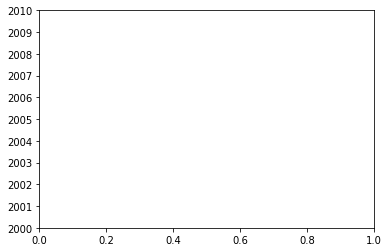

In [118]:
plt.plot(pd.rolling_std(sub_df_dict[('PRDS-000472',"MET-000599",'Osmolality')]["Value"],window=5),tt,"o",)

In [134]:
len(sub_df["Manufacture Date"][pd.rolling_std(sub_df["Value"],window=5).notnull()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """Entry point for launching an IPython kernel.


50

In [138]:
pd.rolling_std(sub_df["Value"],window=5).notnull()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """Entry point for launching an IPython kernel.


84562    False
84556    False
84557    False
84558    False
84559     True
84560     True
84561     True
84563     True
84576     True
84577     True
84578     True
84579     True
84580     True
84581     True
84582     True
84583     True
84584     True
84585     True
84554     True
84555     True
84234     True
84493     True
84494     True
84236     True
84237     True
84238     True
84239     True
84240     True
84241     True
84242     True
84235     True
84487     True
84488     True
84489     True
84490     True
84491     True
84492     True
84486     True
85026     True
85025     True
85024     True
85023     True
85022     True
85021     True
84899     True
84896     True
84897     True
84895     True
84894     True
84893     True
84892     True
85027     True
84898     True
85028     True
Name: Value, dtype: bool